**Regression with BIWI head pose dataset**

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

**Getting and Converting data**

In [4]:
path = untar_data(URLs.BIWI_HEAD_POSE)

There's some kind of calibration numbers that they provide in a little file which I had to read in:

In [5]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [0]:
fname = '09/frame_00667_rgb.jpg'

In [0]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

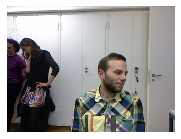

In [8]:
img = open_image(path/fname)
img.show()

In [9]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [0]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [11]:
get_ctr(fname)

tensor([263.9104, 428.5814])

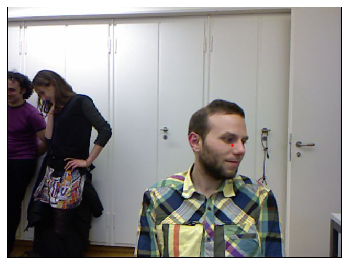

In [12]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

**Creating a DataSet**

I'm going to split it according to some function. So in this case, the files they gave us are from videos. So I picked just one folder (13) to be my validation set (i.e. a different person). So again, I was trying to think about how do I validate this fairly, so I said the the fair validation would be to make sure that it works well on a person that it's never seen before. So my validation set is all going to be a particular person.

In [0]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

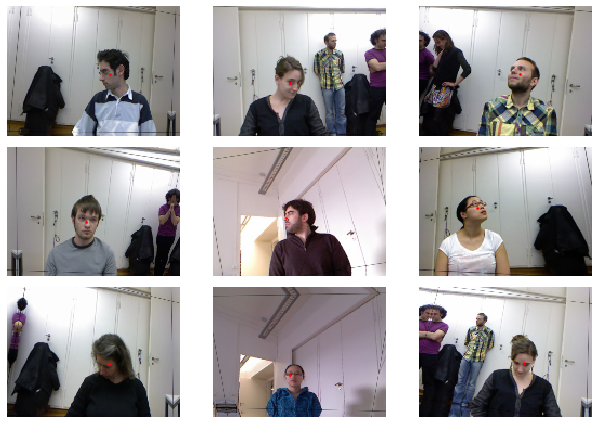

In [14]:
data.show_batch(3, figsize=(9,6))

**Train Model**

In [15]:
learn = cnn_learner(data, models.resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 266MB/s]


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


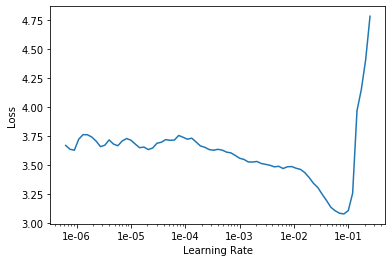

In [16]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 2e-2

In [18]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.122811,0.003360,02:58
1,0.042368,0.010096,02:58
2,0.013967,0.002920,02:58
3,0.008530,0.001169,03:00
4,0.006504,0.001479,03:00


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

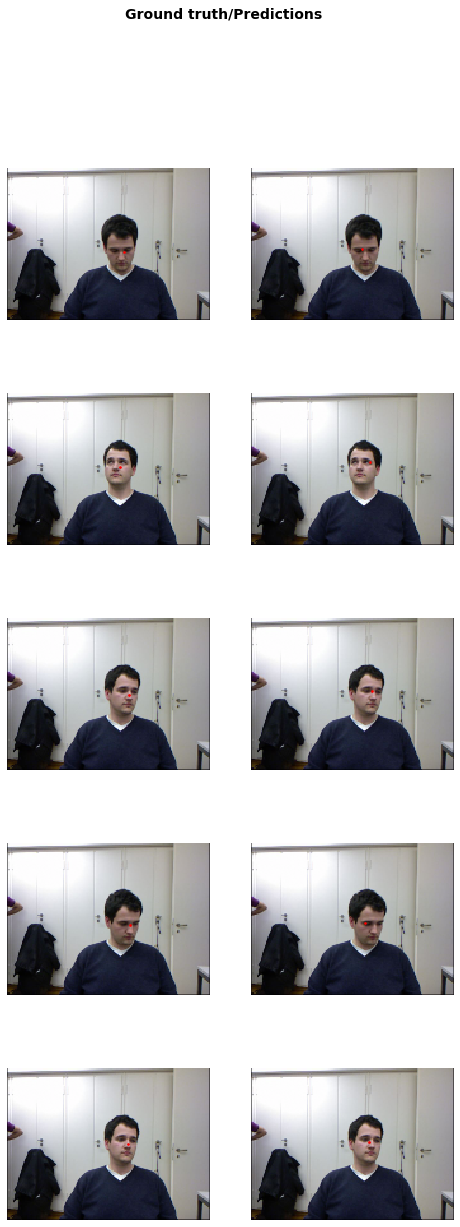

In [21]:
learn.show_results()

**Data Augmentation**

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

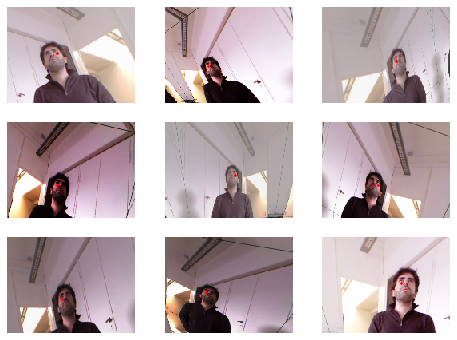

In [23]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))